# Dynamics Simulations

There are weird things going on with the simulator that I must check out.

In [45]:
from bioreaction.simulation.med_sim import MedSimParams
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.simulation.basic_sim import convert_model

import diffrax as dfx
import jax
import pandas as pd
import numpy as np
from scipy import integrate
from functools import partial
from copy import deepcopy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
jax.config.update('jax_platform_name', 'cpu')

# from src.utils.misc.units import per_mol_to_per_molecule
def per_mol_to_per_molecule(per_mol):
    """ Translate a value from the unit of per moles to per molecules.
    The number of M of mRNA in a cell was calculated using the average 
    number of mRNA in an E. coli cell (100 molecules) and the average volume of an E.
    coli cell (1.1e-15 L) to give ca. 1 molecule ~ 1.50958097 nM ~ 1.50958097e-9 M"""
    return np.multiply(per_mol, 1.50958097/np.power(10, 9))


def clear_gpu():
    backend = jax.lib.xla_bridge.get_backend()
    for buf in backend.live_buffers(): buf.delete()


In [2]:



def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else:
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def make_params(model, scale_rates=True):
    sim_model = convert_model(model)

    if scale_rates:
        m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
    else:
        m = 1
    inputs = sim_model.inputs
    outputs = sim_model.outputs
    forward_rates = sim_model.forward_rates/m
    reverse_rates = sim_model.reverse_rates/m
    # batch = 40
    # reverse_rates = reverse_rates * \
    #     np.ones((batch, sim_model.reverse_rates.shape[0]))
    # reverse_rates = reverse_rates * np.random.random(reverse_rates.shape)
    return inputs, outputs, forward_rates, reverse_rates, m

In [3]:
num_species = 3
input_species_idx = 0

Keq = np.array(
    [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]]
)
a = np.ones(3) * 0.08333        # Creation rate
d = np.ones(3) * 0.0008333      # Degradation rate
ka = np.ones_like(Keq) * per_mol_to_per_molecule(1000000)   # Association rate
kd = ka/Keq                     # Dissociation rate

model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species = model.species[-num_species:] + model.species[:-num_species]


model = update_model_rates(model, a, d, ka, kd)
inputs, outputs, forward_rates, reverse_rates, rate_scaling = make_params(model)

a_sig = a * 1
a_sig[input_species_idx] = a_sig[input_species_idx] * 2
new_model = update_model_rates(deepcopy(model), a_sig, d, ka, kd)
y0 = np.zeros(len(model.species))
t0 = 0.0
t1 = 200000.0
dt0 = rate_scaling
tmax = int(t1/2/dt0+1e4)
# tmax = 16**7
signal = None
signal_onehot = None
solver = dfx.Tsit5()
saveat = dfx.SaveAt(
    t0=True, t1=True, steps=True)

In [4]:



def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 signal, signal_onehot: np.ndarray,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates, reverse_rates=reverse_rates
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0,
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6))  # 16**4)


x1 = bioreaction_sim_dfx_expanded(
    y0=y0,
    t0=0.0,
    t1=t1/2,
    dt0=dt0,
    inputs=inputs,
    outputs=outputs,
    forward_rates=forward_rates,
    reverse_rates=reverse_rates,
    signal=None,
    signal_onehot=None,
    solver=dfx.Tsit5(),
    saveat=dfx.SaveAt(
        t0=True, t1=True, steps=True),
    max_steps=tmax)
# reverse_rates=reverse_rates)

inputs, outputs, forward_rates, reverse_rates, m2 = make_params(new_model)
dt0 = m2

x2 = bioreaction_sim_dfx_expanded(
    y0=x1.ys[np.argmax(x1.ts >= np.inf)-1, :],
    t0=t1/2,
    t1=t1,
    dt0=dt0,
    inputs=inputs,
    outputs=outputs,
    forward_rates=forward_rates,
    reverse_rates=reverse_rates,
    signal=None,
    signal_onehot=None,
    solver=dfx.Tsit5(),
    saveat=dfx.SaveAt(
        t0=True, t1=True, steps=True),
    max_steps=tmax)


In [5]:
xs1 = x1.ys[:x1.stats['num_accepted_steps'], :] #* m1
xs2 = x2.ys[:x2.stats['num_accepted_steps'], :] #* m2
ts1 = x1.ts[:x1.stats['num_accepted_steps']]
ts2 = x2.ts[:x2.stats['num_accepted_steps']]

In [6]:
x1.ys.shape

(1210049, 9)

In [7]:
x1.ys[np.argmax(x1.ts >= np.inf)-1, :]

Array([  88.07425 ,   88.074135,   88.07402 , 7758.222   , 7758.2104  ,
       7758.194   , 7758.202   , 7758.1895  , 7758.176   ],      dtype=float32, weak_type=True)

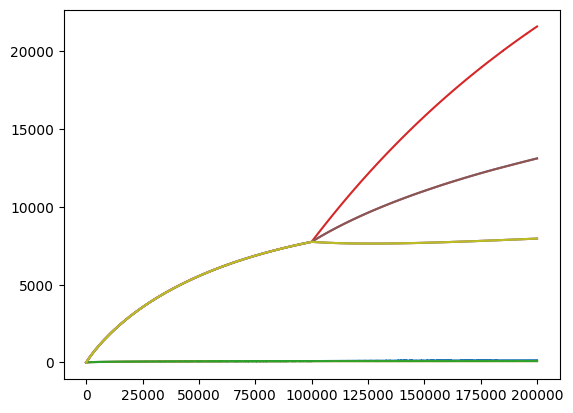

In [8]:
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2]))

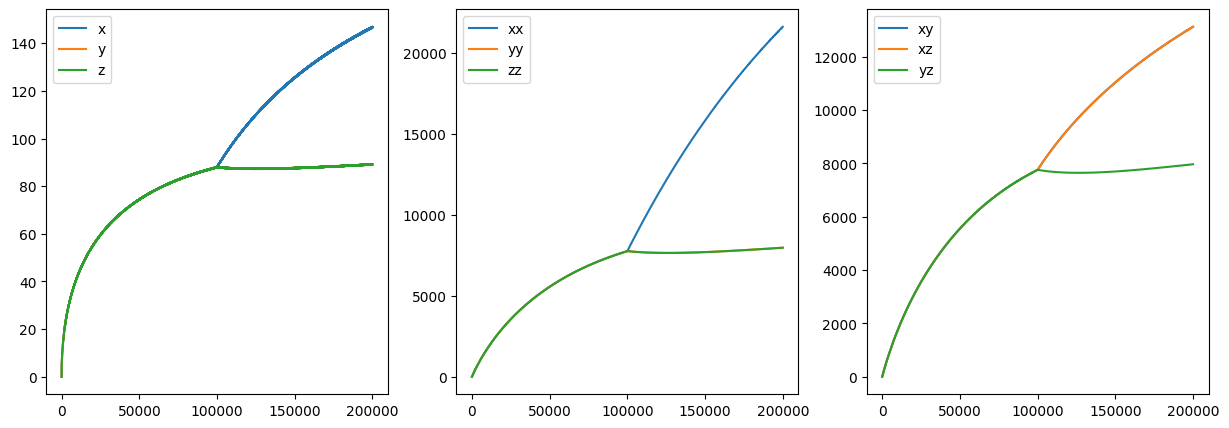

In [9]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 0:3])
plt.legend(['x', 'y', 'z'])
ax = plt.subplot(1,3,2)
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 3])
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 6])
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 8])
plt.legend(['xx', 'yy', 'zz'])
ax = plt.subplot(1,3,3)
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 4])
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 5])
plt.plot(np.concatenate([ts1, ts2]), np.concatenate([xs1, xs2])[:, 7])
plt.legend(['xy', 'xz', 'yz'])

In [10]:
# b = 5
# plt.figure(figsize=(5*b, 5))
# for i in range(b):
# # i = 1
#     ax = plt.subplot(1,b, i+1)
#     plt.plot(x.ts[i], (x.ys*m)[i])

## Compare to a stupid simple simulation

Text(0.5, 1.0, 'Output (y)')

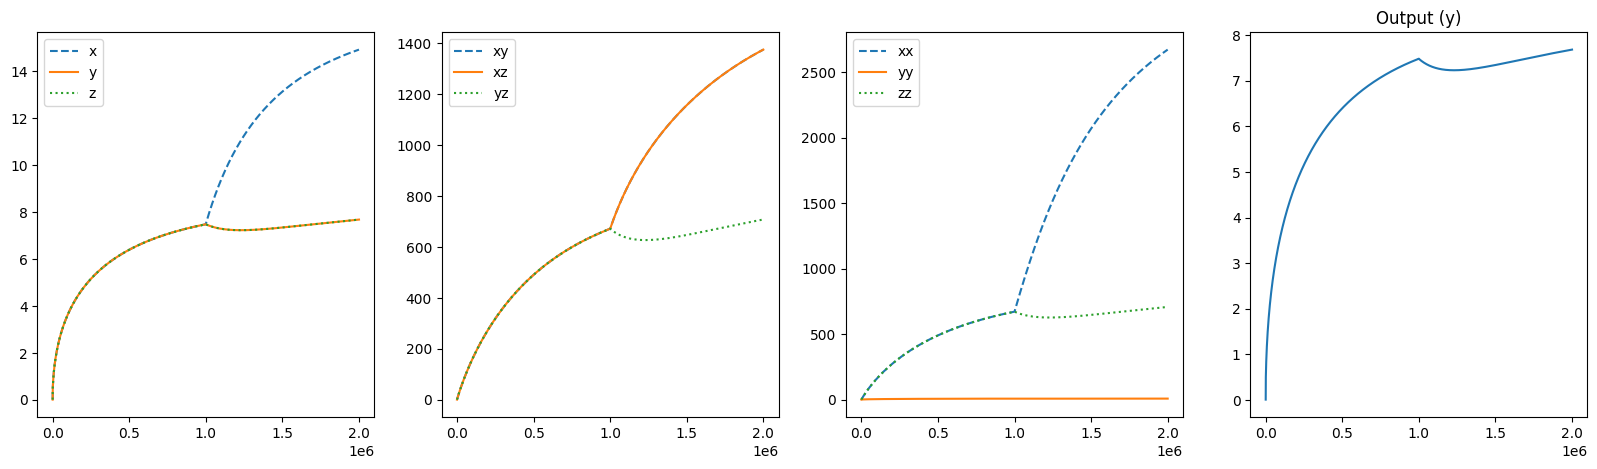

In [11]:
x = 0
y = 0
z = 0
xy = 0
xz = 0
yz = 0
xx = 0
yy = 0
zz = 0

x_res = []
y_res = []
z_res = []
xy_res = []
xz_res = []
yz_res = []
xx_res = []
yy_res = []
zz_res = []

# reverse rates
k00m = kd[0, 0]
k01m = kd[0, 1]
k02m = kd[0, 2]
k11m = kd[1, 1]
k12m = kd[1, 2]
k22m = kd[2, 2]

degx = d[0]
degy = d[1]
degz = d[2]

k00 = ka[0, 0]
k01 = ka[0, 1]
k02 = ka[0, 2]
k11 = ka[1, 1]
k12 = ka[1, 2]
k22 = ka[2, 2]

prodx = a[0]
prody = a[1]
prodz = a[2]

m = prodx
# m=1

k00m, k01m, k02m, k11m, k12m, k22m, degx, degy, degz, k00, k01, k02, k11, k12, k22, prodx, prody, prodz = k00m/m, k01m/m,  k02m/m, k11m/m, k12m/m, k22m/m, degx/m, degy/m, degz/m, k00/m, k01/m, k02/m, k11/m, k12/m, k22/m, prodx/m, prody/m, prodz/m

dt = 0.1
dt = m
n = 2000000
tmax = n*dt

for i in range(n):
    xnew = x+(prodx-degx*x-k01*x*y-k02*x*z+k01m *
              xy+k02m*xz - k00*x*x+k00m*xx)*dt
    ynew = y+(prody-degy*y-k01*x*y-k12*y*z+k01m *
              xy+k12m*yz - k11*y*y+k11m*yy)*dt
    znew = z+(prodz-degz*z-k02*x*z-k12*y*z+k02m *
              xz+k12m*yz - k22*z*z+k22m*zz)*dt

    xynew = xy+(k01*x*y-k01m*xy)*dt
    xznew = xz+(k02*x*z-k02m*xz)*dt
    yznew = yz+(k12*z*y-k12m*yz)*dt

    xxnew = xx+(k00*x*x-k00m*xx)*dt
    yynew = yy + (k11*y*y-k11m*yy)*dt
    zznew = yy + (k22*z*z-k22m*zz)*dt

    x = xnew 
    y = ynew 
    z = znew 
    xy = xynew 
    xz = xznew 
    yz = yznew 
    xx = xxnew 
    yy = yynew 
    zz = zznew 

    if i == int(n/2):
        prodx = prodx*2

    x_res.append(x * m)
    y_res.append(y * m)
    z_res.append(z * m)
    xy_res.append(xy * m)
    xz_res.append(xz * m)
    yz_res.append(yz * m)
    xx_res.append(xx * m)
    yy_res.append(yy * m)
    zz_res.append(zz * m)


plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 4, 1)
plt.plot(x_res, '--')
plt.plot(y_res)
plt.plot(z_res, ":")
plt.legend(['x', 'y', 'z'])


ax = plt.subplot(1, 4, 2)
plt.plot(xy_res, '--')
plt.plot(xz_res)
plt.plot(yz_res, ":")
plt.legend(['xy', 'xz', 'yz'])

ax = plt.subplot(1, 4, 3)
plt.plot(xx_res, '--')
plt.plot(y_res)
plt.plot(zz_res, ":")
plt.legend(['xx', 'yy', 'zz'])


ax = plt.subplot(1, 4, 4)
plt.plot(y_res)
plt.title('Output (y)')


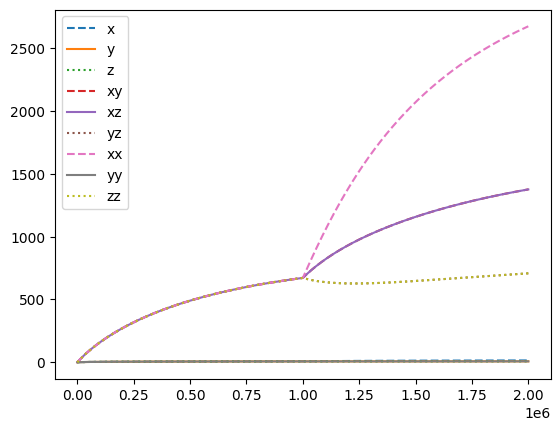

In [12]:
plt.plot(x_res, '--')
plt.plot(y_res)
plt.plot(z_res, ":")
plt.plot(xy_res, '--')
plt.plot(xz_res)
plt.plot(yz_res, ":")
plt.plot(xx_res, '--')
plt.plot(y_res)
plt.plot(zz_res, ":")
plt.legend(['x', 'y', 'z'] + ['xy', 'xz', 'yz']+['xx', 'yy', 'zz'])

## Compare to dynamic sim but in for loop

Seems like the simple `for` loop version and the inner part of the solver do not match. The naive solution (red) converges quickly, while the concentrations of the bound together species in the solver (blue) continue to grow for much longer.

In [13]:
x=0 
y=0 
z=0 
xy=0 
xz=0 
yz=0 
xx=0 
yy=0 
zz=0 

k00m = kd[0, 0]
k01m = kd[0, 1]
k02m = kd[0, 2]
k11m = kd[1, 1]
k12m = kd[1, 2]
k22m = kd[2, 2]

degx = d[0]
degy = d[1]
degz = d[2]

k00 = ka[0, 0]
k01 = ka[0, 1]
k02 = ka[0, 2]
k11 = ka[1, 1]
k12 = ka[1, 2]
k22 = ka[2, 2]

prodx = a[0]
prody = prodx
prodz = prodx

inputs, outputs, forward_rates, reverse_rates, m1 = make_params(model, scale_rates=True)
dt = m1
# m1 = m1*2
k00m, k01m, k02m, k11m, k12m, k22m, degx, degy, degz, k00, k01, k02, k11, k12, k22, prodx, prody, prodz = k00m/m1, k01m/m1,  k02m/m1, k11m/m1, k12m/m1, k22m/m1, degx/m1, degy/m1, degz/m1, k00/m1, k01/m1, k02/m1, k11/m1, k12/m1, k22/m1, prodx/m1, prody/m1, prodz/m1

spec_conc = y0


# degx = degx.astype(np.float32)
# degy = degy.astype(np.float32)
# degz = degz.astype(np.float32)
# prodx = prodx.astype(np.float32)
# prody = prody.astype(np.float32)
# prodz = prodz.astype(np.float32)
# k00 = k00.astype(np.float32)
# k00m = k00m.astype(np.float32)
# k01 = k01.astype(np.float32)
# k01m = k01m.astype(np.float32)
# k02 = k02.astype(np.float32)
# k02m = k02m.astype(np.float32)
# k11 = k11.astype(np.float32)
# k11m = k11m.astype(np.float32)
# k12 = k12.astype(np.float32)
# k12m = k12m.astype(np.float32)
# k22 = k22.astype(np.float32)
# k22m = k22m.astype(np.float32)


In [14]:
dt0 = dt
tt = int(t1 / dt0)
spec_all1 = np.zeros((tt, len(model.species)))
spec_all2 = np.zeros((tt, len(model.species)))
outin_abs = np.nan_to_num((outputs - inputs) / np.abs((outputs - inputs)))

for i in range(tt):
    # Solver
    concentration_factors_in = np.prod(
        np.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = np.prod(
        np.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    spec_conc_new = (forward_delta - reverse_delta) @ (outputs - inputs) * dt0
    spec_conc += spec_conc_new
    spec_all1[i] = spec_conc * m1

    # Naive
    xnew = (prodx - degx*x - k01*x*y - k02*x*z + k01m *
            xy + k02m*xz - 2*k00*x*x + 2*k00m*xx) * dt0
    ynew = (prody - degy*y - k01*x*y - k12*y*z + k01m *
            xy + k12m*yz - 2*k11*y*y + 2*k11m*yy) * dt0
    znew = (prodz - degz*z - k02*x*z - k12*y*z + k02m *
            xz + k12m*yz - 2*k22*z*z + 2*k22m*zz) * dt0

    xynew = (k01*x*y-k01m*xy)*dt0
    xznew = (k02*x*z-k02m*xz)*dt0
    yznew = (k12*z*y-k12m*yz)*dt0

    xxnew = (k00*x*x-k00m*xx)*dt0
    yynew = (k11*y*y-k11m*yy)*dt0
    zznew = (k22*z*z-k22m*zz)*dt0

    x = x + xnew
    y = y + ynew
    z = z + znew
    xy = xy + xynew
    xz = xz + xznew
    yz = yz + yznew
    xx = xx + xxnew
    yy = yy + yynew
    zz = zz + zznew

    if i == int(tt/2):
        prodx = prodx*2
        forward_rates = np.array(forward_rates)
        forward_rates[9] = forward_rates[9] * 2

    spec_all2[i] = np.array([[x, y, z, xx, xy, xz, yy, yz, zz]])*m1


Text(0.5, 1.0, 'Output (y)')

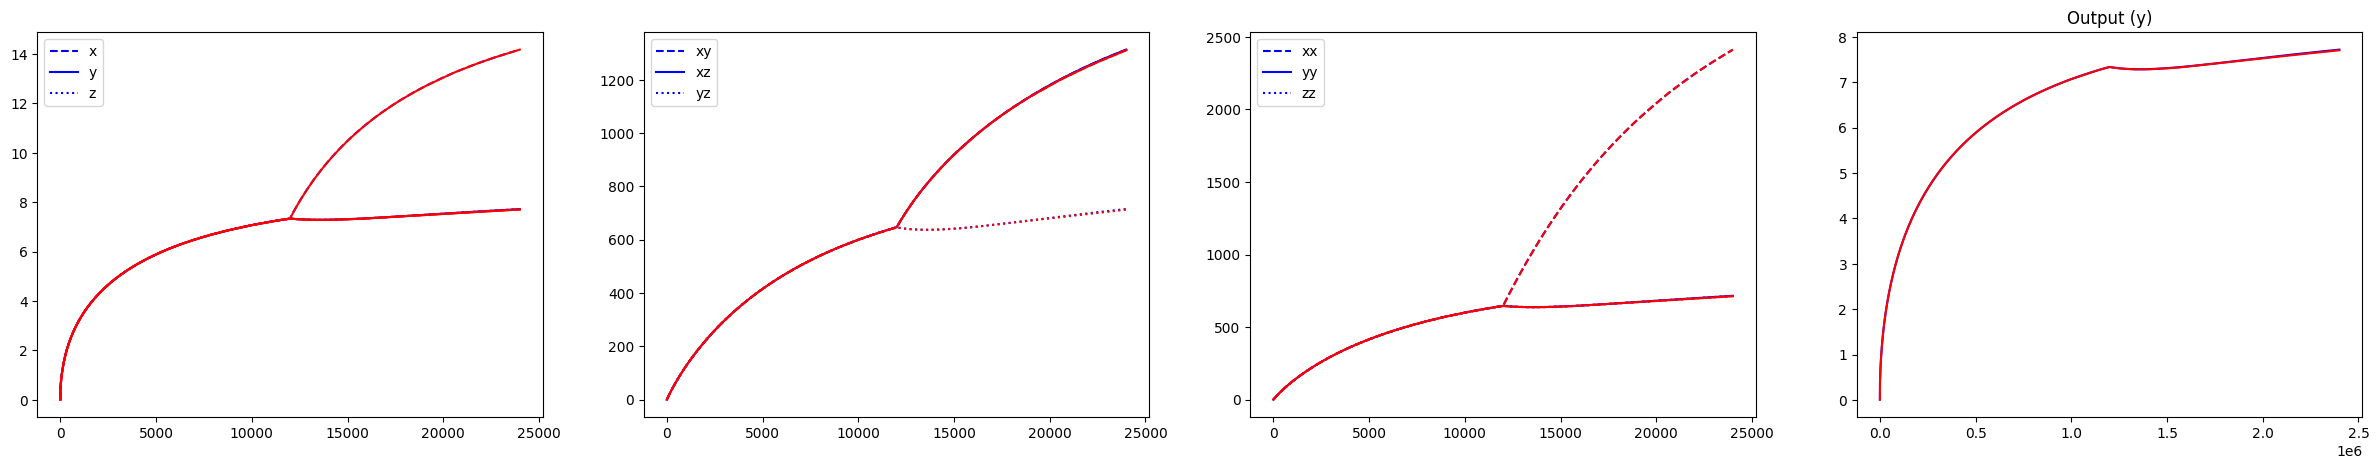

In [15]:
plt.figure(figsize=(30, 5))

ax = plt.subplot(1, 4, 1)
plt.plot(spec_all2[::100, 0], 'b--')
plt.plot(spec_all2[::100, 1], 'b')
plt.plot(spec_all2[::100, 2], "b:")
plt.plot(spec_all1[::100, :3], 'r')
plt.legend(['x', 'y', 'z'])


ax = plt.subplot(1, 4, 2)
plt.plot(spec_all2[::100, 4], 'b--')
plt.plot(spec_all2[::100, 5], 'b')
plt.plot(spec_all2[::100, 7], "b:")
plt.plot(spec_all1[::100, 4], 'r--')
plt.plot(spec_all1[::100, 5], 'r')
plt.plot(spec_all1[::100, 7], "r:")
plt.legend(['xy', 'xz', 'yz'])

ax = plt.subplot(1, 4, 3)
plt.plot(spec_all2[::100, 3], 'b--')
plt.plot(spec_all2[::100, 6], 'b')
plt.plot(spec_all2[::100, 8], "b:")
plt.plot(spec_all1[::100, 3], 'r--')
plt.plot(spec_all1[::100, 6], 'r')
plt.plot(spec_all1[::100, 8], "r:")
plt.legend(['xx', 'yy', 'zz'])


ax = plt.subplot(1, 4, 4)
plt.plot(spec_all2[:, 1], 'b')
plt.plot(spec_all1[:, 1], 'r')
plt.title('Output (y)')

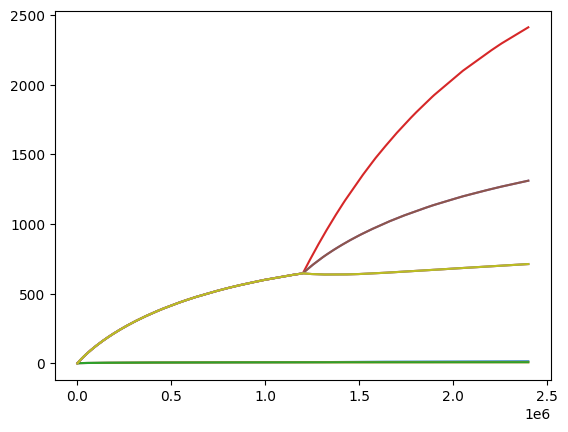

In [16]:
plt.plot(spec_all1)

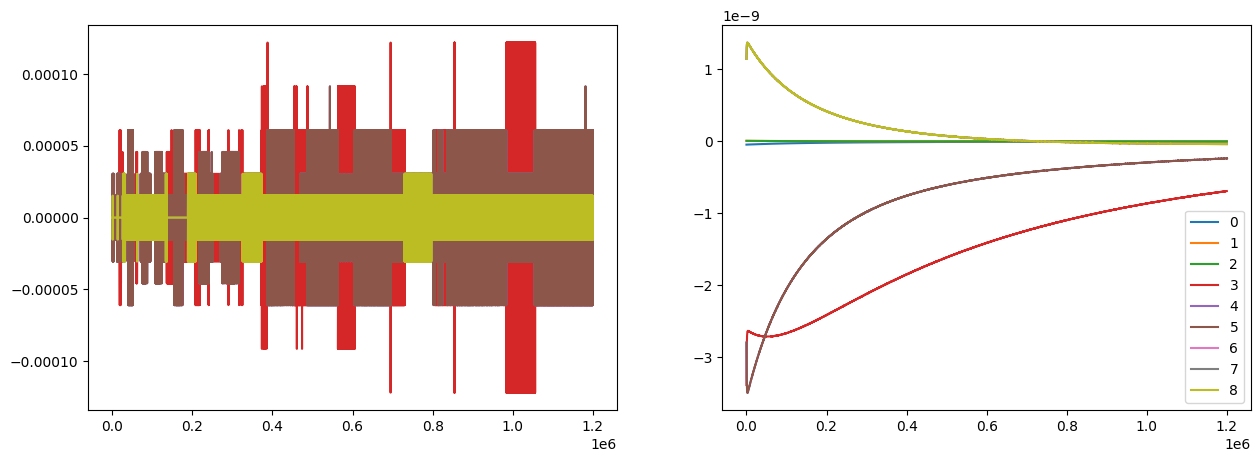

In [17]:
# plt.plot(np.gradient(spec_all1[t00:, 5])[1:] - np.gradient(spec_all1[t00:, 5])[:-1])
grads1 = np.concatenate([np.expand_dims(np.gradient(np.gradient(spec_all1[:, i])), axis=1) for i in range(len(model.species))], axis=1)
grads2 = np.concatenate([np.expand_dims(np.gradient(np.gradient(spec_all2[:, i])), axis=1) for i in range(len(model.species))], axis=1)

plt.figure(figsize=(15, 5))
ax = plt.subplot(1,2,1)
plt.plot(grads1[int(tt/2) + 100:-2, :], alpha=1)
ax = plt.subplot(1,2,2)
plt.plot(grads2[int(tt/2) + 100:-2, :], alpha=1)
plt.legend(np.arange(len(model.species)))

The matrix multiplication form of the bioreaction matrix multiplication ode step has a very noisy second derivative compared to its simplified, explicitly written counterpart.

## Why is this bad?

They should be the same for one, but there are also extreme cases where things get weird and I think this has something to do with it.

In [18]:
num_species = 3
input_species_idx = 0

Keq = np.array(
    [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]]
) * 0.01
Keq[0, 0] = 0.5
a = np.ones(3) * 0.08333        # Creation rate
a[1] = a[1] * 1.5 
a[2] = a[2] * 0.8 
d = np.ones(3) * 0.0008333      # Degradation rate
ka = np.ones_like(Keq) * per_mol_to_per_molecule(1000000)   # Association rate
kd = ka/Keq                     # Dissociation rate

model = update_model_rates(model, a, d, ka, kd)
inputs, outputs, forward_rates, reverse_rates, rate_scaling = make_params(model)

a_sig = a * 1
a_sig[input_species_idx] = a_sig[input_species_idx] * 2
new_model = update_model_rates(deepcopy(model), a_sig, d, ka, kd)
y0 = np.zeros(len(model.species))
t0 = 0.0
t1 = 8000.0
dt0 = rate_scaling
tmax = int(t1/dt0 + 10000)

In [ ]:


def num_unsteadied(comparison):
    return np.sum(np.abs(comparison) > 0.1)

In [58]:
def bioreaction_sim_dfx_expanded(y0, t0, t1, dt0,
                                 inputs, outputs, forward_rates, reverse_rates,
                                 signal, signal_onehot: np.ndarray,
                                 solver=dfx.Tsit5(),
                                 saveat=dfx.SaveAt(
                                     t0=True, t1=True, steps=True),
                                 max_steps=16**5):
    term = dfx.ODETerm(
        partial(bioreaction_sim_expanded,
                inputs=inputs, outputs=outputs,
                forward_rates=forward_rates, reverse_rates=reverse_rates
                )
    )
    return dfx.diffeqsolve(term, solver,
                           t0=t0, t1=t1, dt0=dt0,
                           y0=y0,
                           saveat=saveat, max_steps=max_steps,
                           stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6))  # 16**4)


def get_full_steady_states(y0, total_time, reverse_rates, params, sim_func):

    ti = params.t_start
    iter_time = datetime.now()
    while True:
        if ti == params.t_start:
            y00 = y0
        else:
            y00 = ys[:, -1, :]

        x_res = sim_func(
            y0=y00, reverse_rates=reverse_rates)

        if np.sum(np.argmax(x_res.ts >= np.inf)) > 0:
            ys = x_res.ys[:, :np.argmax(x_res.ts >= np.inf), :]
            ts = x_res.ts[:, :np.argmax(x_res.ts >= np.inf)] + ti
        else:
            ys = x_res.ys
            ts = x_res.ts + ti

        if ti == params.t_start:
            ys_full = ys
            ts_full = ts
        else:
            ys_full = np.concatenate([ys_full, ys], axis=1)
            ts_full = np.concatenate([ts_full, ts], axis=1)

        if (num_unsteadied(ys[:, -1, :] - y00) == 0) or (ti >= total_time):
            break
        print('Steady states: ', ti, ' iterations. ', (num_unsteadied(
            ys[:, -1, :] - y00)), ' left to steady out. ', datetime.now() - iter_time)

        ti += params.t_end - params.t_start

    return np.array(ys), np.array(ys_full), np.array(ts_full[0])


num_runs = 2
# for ti in np.arange(0.0, t1/2, t1/2/num_runs):
ti = 0


params_steady = MedSimParams(t_start=0, t_end=t1/2/num_runs, delta_t=dt0,
                             poisson_sim_reactions=None, brownian_sim_reaction=None)
xs1_bad, x1_bad_full, t1_bad_full = get_full_steady_states(
    y0=np.repeat(np.expand_dims(y0, axis=0), repeats=2, axis=0),
    total_time=t1/2, reverse_rates=np.repeat(np.expand_dims(reverse_rates, axis=0), repeats=2, axis=0),
    params=params_steady, sim_func=jax.vmap(partial(
        bioreaction_sim_dfx_expanded,
        t0=0,
        t1=t1/2/num_runs,
        dt0=dt0,
        inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        signal=None,
        signal_onehot=None,
        solver=dfx.Tsit5(),
        saveat=dfx.SaveAt(
            t1=True),
        max_steps=tmax))
)

inputs, outputs, forward_rates, reverse_rates, m2 = make_params(new_model)
dt0 = m2

params_final = MedSimParams(t_start=0, t_end=t1/2/num_runs, delta_t=dt,
                            poisson_sim_reactions=None, brownian_sim_reaction=None)
xs2_bad, x2_bad_full, t2_bad_full = get_full_steady_states(
    y0=x1_bad_full[:, -1, :],
    total_time=t1/2, reverse_rates=np.repeat(np.expand_dims(reverse_rates, axis=0), repeats=2, axis=0),
    params=params_steady, sim_func=jax.vmap(partial(
        bioreaction_sim_dfx_expanded,
        t0=0,
        t1=t1/2/num_runs,
        dt0=dt0,
        inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        signal=None,
        signal_onehot=None,
        solver=dfx.Tsit5(),
        saveat=dfx.SaveAt(ts=np.linspace(params_final.t_start, params_final.t_end, 100)),
        # saveat=dfx.SaveAt(
        #         t0=True, t1=True, steps=True),
        max_steps=tmax))
)
t2_bad_full = t2_bad_full + t1/2

# for ti in np.arange(t1/2, t1, t1/2/num_runs):
# ti = t1/2
# while True:
#     if ti == t1/2:
#         y00 = x1_bad_full[:, -1, :]
#     else:
#         y00 = xs2_bad[:, -1, :]
#     x2_bad = jax.vmap(
#         partial(
#             bioreaction_sim_dfx_expanded,
#             t0=0,
#             t1=t1/2/num_runs,
#             dt0=dt0,
#             inputs=inputs,
#             outputs=outputs,
#             forward_rates=forward_rates,
#             # reverse_rates=reverse_rates,
#             signal=None,
#             signal_onehot=None,
#             solver=dfx.Tsit5(),
#             saveat=dfx.SaveAt(
#                 t0=True, t1=True, steps=True),
#             max_steps=tmax))(
#         y0=y00,
#         reverse_rates=np.repeat(np.expand_dims(reverse_rates, axis=0), repeats=2, axis=0))
#     xs2_bad = x2_bad.ys[:, :np.argmax(x2_bad.ts >= np.inf), :]   # [:x2_bad.stats['num_accepted_steps'], :]
#     ts2_bad = x2_bad.ts[:, :np.argmax(x2_bad.ts >= np.inf)] + ti  # [:x2_bad.stats['num_accepted_steps']]
#     if ti == t1/2:
#         x2_bad_full = xs2_bad
#         t2_bad_full = ts2_bad
#     else:
#         x2_bad_full = np.concatenate([x2_bad_full, xs2_bad], axis=1)
#         t2_bad_full = np.concatenate([t2_bad_full, ts2_bad], axis=1)


#     if x2_bad.ys.ndim == 3 and (x2_bad.ys.shape[1] == 1):
#         xs2_bad = x2_bad.ys
#         ts2_bad = x2_bad.ts + ti
#     else:
#         xs2_bad = x2_bad.ys[:, :np.argmax(x2_bad.ts >= np.inf), :]   # [:x2_bad.stats['num_accepted_steps'], :]
#         ts2_bad = x2_bad.ts[:, :np.argmax(x2_bad.ts >= np.inf)] + ti  # [:x2_bad.stats['num_accepted_steps']]

#     if ti == 0:
#         x2_bad_full = xs2_bad
#         t2_bad_full = ts2_bad
#     else:
#         x2_bad_full = np.concatenate([x2_bad_full, xs2_bad], axis=1)
#         t2_bad_full = np.concatenate([t2_bad_full, ts2_bad], axis=1)

#     if (num_unsteadied(xs2_bad[:, -1, :] - y00) == 0) or (ti >= t1):
#         break
#     print('Final has ', num_unsteadied(xs2_bad[:, -1, :] - y00), ' circuits left to steady')
#     ti += t1/2/num_runs


Steady states:  0  iterations.  18  left to steady out.  0:00:01.672650
Steady states:  2000.0  iterations.  18  left to steady out.  0:00:04.477866
Steady states:  0  iterations.  18  left to steady out.  0:00:02.455203
Steady states:  2000.0  iterations.  18  left to steady out.  0:00:04.893441


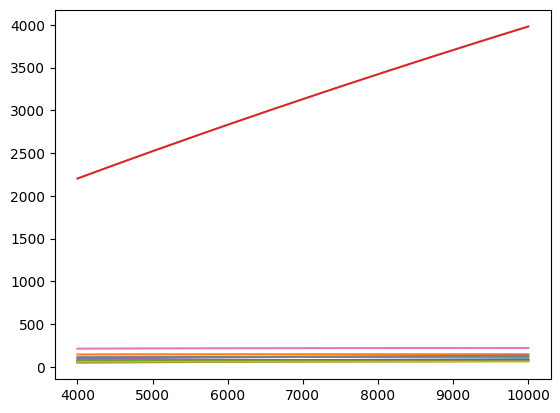

In [59]:
plt.plot(t2_bad_full, x2_bad_full[0])


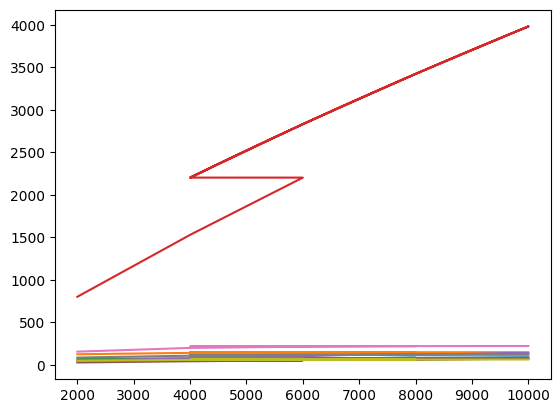

In [41]:
plt.plot(np.concatenate([t1_bad_full, t2_bad_full], axis=1)[0], np.concatenate([x1_bad_full, x2_bad_full], axis=1)[0])

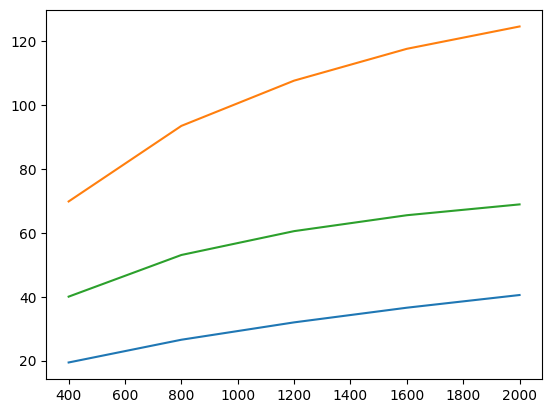

In [ ]:
plt.plot(np.concatenate([t1_bad_full, t2_bad_full], axis=1)[0, :5], np.concatenate([x1_bad_full, x2_bad_full], axis=1)[0, :5, :3])

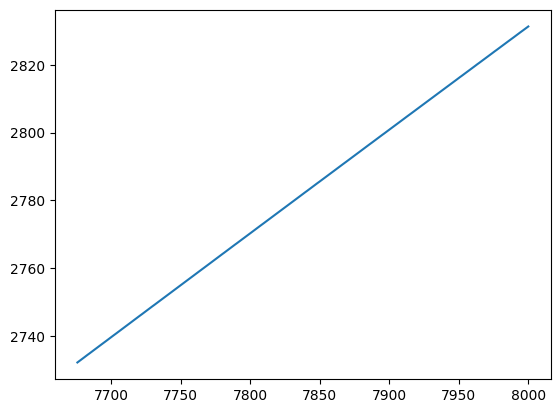

In [ ]:
plt.plot(np.concatenate([t1_bad_full, t2_bad_full], axis=1)[0, int(-t1/10):], np.concatenate([x1_bad_full, x2_bad_full], axis=1)[0, int(-t1/10):, 3])


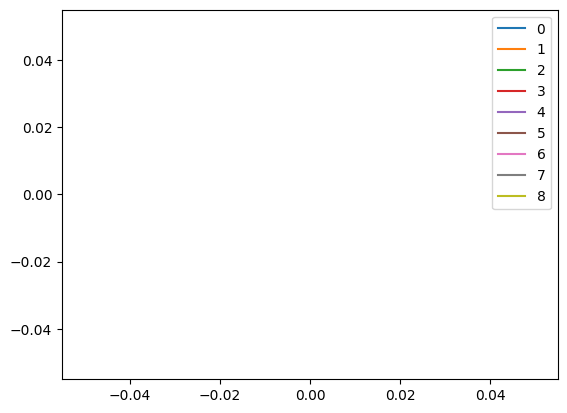

In [ ]:
grads_bad = np.concatenate([np.expand_dims(np.gradient(np.gradient(xs2_bad[0, :, i])), axis=1) for i in range(len(model.species))], axis=1)

plt.plot(grads_bad[:-1000, :], alpha=1)
plt.legend(np.arange(len(model.species)))